[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/time-travel.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239536-lesson-5-time-travel)

# Time travel

## Review

human-in-the-loopの動機について議論しました。

(1) `承認(Approval)` - エージェントを中断し、状態をユーザーに表示し、ユーザーがアクションを承認できるようにします

(2) `デバッグ(debugging)` - グラフを巻き戻して問題を再現したり回避したりすることができます

(3) `編集(Editing)` - 状態を変更することができます 

ブレークポイントがグラフを特定のノードで停止させたり、グラフが動的に中断したりする方法をご紹介しました。

次に、人間の承認を得て処理を進める方法、または人間のフィードバックを直接反映させてグラフの状態を編集する方法をご紹介しました。

## Goals

次に、LangGraphが過去の状態を閲覧、再実行、さらにはforkすることによって、どのように[デバッグをサポートしているか](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/time-travel/)を示します。

これを`タイムトラベル(time travel)`と呼びます。




In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

In [1]:
import os
import getpass


def _set_env(var: str) -> None:
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

エージェントを構築してみましょう。


In [2]:
from langchain_openai import ChatOpenAI


def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


def divide(a: int, b: int) -> float:
    """divides a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

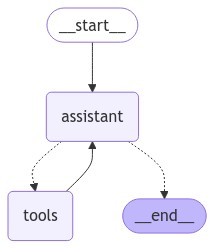

In [3]:
from IPython.display import Image, display

from langchain_core.messages.base import BaseMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")


# Node
def assistant(state: MessagesState) -> dict[str, list[BaseMessage]]:
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

前回と同じように実行してみましょう。

In [4]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_jl5hVOp03T2b7U6bRzbCxDtx)
 Call ID: call_jl5hVOp03T2b7U6bRzbCxDtx
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


## 履歴を閲覧

`get_state` を使用して、`thread_id` を指定すれば、グラフの **現在の** 状態を確認することができます!


In [5]:
graph.get_state({"configurable": {"thread_id": "1"}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='5fb7edb0-1bcc-4ddb-acd5-6403f11e28e1'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jl5hVOp03T2b7U6bRzbCxDtx', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 131, 'total_tokens': 148, 'completion_tokens_details': {'reasoning_tokens': 0}, 'prompt_tokens_details': {'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_e5e4913e83', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-65d5266e-396f-4441-9954-9054d6fb3233-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_jl5hVOp03T2b7U6bRzbCxDtx', 'type': 'tool_call'}], usage_metadata={'input_tokens': 131, 'output_tokens': 17, 'total_tokens': 148}), ToolMessage(content='6', name='multiply', id='0b31d214-1

また、エージェントの状態の履歴を閲覧することもできます。

`get_state_history` を使用すると、それ以前のすべてのステップの状態を取得できます。



In [6]:
all_states = [s for s in graph.get_state_history(thread)]

In [7]:
len(all_states)

5

最初の要素は、現在の状態です、`get_state` で取得したものと同じです。



In [8]:
all_states[-2]

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='5fb7edb0-1bcc-4ddb-acd5-6403f11e28e1')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef847e0-65dc-6da2-8000-75801c66da1a'}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {}}, created_at='2024-10-07T07:30:27.933115+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef847e0-65d8-6f1c-bfff-33b6a34b5f65'}}, tasks=(PregelTask(id='22fd2370-95e7-5095-718d-4df75a8589f1', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None),))

上記の内容はすべてここで可視化できます。

![fig1.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038211b544898570be3_time-travel1.png)

## Replaying 

どのステップからでもエージェントを再実行できます。

![fig2.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038a0bd34b541c78fb8_time-travel2.png)

では、人間の入力を受け取ったステップを振り返ってみましょう!



In [9]:
to_replay = all_states[-2]

In [10]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='5fb7edb0-1bcc-4ddb-acd5-6403f11e28e1')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef847e0-65dc-6da2-8000-75801c66da1a'}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {}}, created_at='2024-10-07T07:30:27.933115+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef847e0-65d8-6f1c-bfff-33b6a34b5f65'}}, tasks=(PregelTask(id='22fd2370-95e7-5095-718d-4df75a8589f1', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None),))

状態を見てみましょう。

In [11]:
to_replay.values

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='5fb7edb0-1bcc-4ddb-acd5-6403f11e28e1')]}

次に呼び出すノードがわかります。


In [12]:
to_replay.next

('assistant',)

また、configには、`checkpoint_id` と `thread_id` が含まれています。

In [13]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef847e0-65dc-6da2-8000-75801c66da1a'}}

ここからreplayするには、configをエージェントに渡すだけです。

グラフは、このチェックポイントがすでに実行済みであることを知っています。

このチェックポイントからreplayするだけです!


In [14]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_Sdii6mjR7tyLZM9qKNVTLmYm)
 Call ID: call_Sdii6mjR7tyLZM9qKNVTLmYm
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


Now, we can see our current state after the agent re-ran.

## Forking

同じステップから実行したい場合、異なる入力で実行したい場合はどうすればよいでしょうか。

これがforkingです。


![fig3.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038f89f2d847ee5c336_time-travel3.png)

In [15]:
to_fork = all_states[-2]
to_fork.values["messages"]

[HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='5fb7edb0-1bcc-4ddb-acd5-6403f11e28e1')]

繰り返しになりますが、私たちはconfigにアクセスできます。

In [16]:
to_fork.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef847e0-65dc-6da2-8000-75801c66da1a'}}

このチェックポイントの状態を変更してみましょう。

`checkpoint_id` を指定して `update_state` を実行するだけです。

`messages` のreducerがどのように動作するかを思い出してください。

* message IDを指定しない限り、追加されます。
* message IDを指定すると、stateに追加するのではなく、messageを上書きします。

なので、messageを上書きするために、message IDを指定するだけでよく、そのIDは `to_fork.values["messages"].id` です。


In [17]:
fork_config = graph.update_state(
    to_fork.config,
    {"messages": [HumanMessage(content="Multiply 5 and 3", id=to_fork.values["messages"][0].id)]},
)

In [18]:
fork_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef8481b-667c-6c73-8001-4b84493cea9d'}}

これにより、forkされた新しいチェックポイントが作成されます。

しかし、メタデータ(例えば、次にどこへ行くかなど)はそのまま残ります!

エージェントの現在の状態がfork(分岐)により更新されていることがわかります


In [19]:
all_states = [state for state in graph.get_state_history(thread)]
all_states[0].values["messages"]

[HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='5fb7edb0-1bcc-4ddb-acd5-6403f11e28e1')]

In [20]:
graph.get_state({"configurable": {"thread_id": "1"}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='5fb7edb0-1bcc-4ddb-acd5-6403f11e28e1')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef8481b-667c-6c73-8001-4b84493cea9d'}}, metadata={'source': 'update', 'step': 1, 'writes': {'__start__': {'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='5fb7edb0-1bcc-4ddb-acd5-6403f11e28e1')]}}, 'parents': {}}, created_at='2024-10-07T07:56:51.767806+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef847e0-65dc-6da2-8000-75801c66da1a'}}, tasks=(PregelTask(id='a31b9b9c-240e-efa5-622d-16b1dfee9022', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None),))

今、ストリーミングを行うと、グラフは、このチェックポイントが一度も実行されていないことを認識します。

そのため、グラフは、単純にreplayされるのではなく、実行されます。


In [21]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 5 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_3tVBhdjK1pSjE3QwtzEb2ggZ)
 Call ID: call_3tVBhdjK1pSjE3QwtzEb2ggZ
  Args:
    a: 5
    b: 3
================================= Tool Message =================================
Name: multiply

15
================================== Ai Message ==================================

The result of multiplying 5 and 3 is 15.


現在の状態は、エージェントの実行が終了した状態であることがわかります。

In [22]:
graph.get_state({"configurable": {"thread_id": "1"}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='5fb7edb0-1bcc-4ddb-acd5-6403f11e28e1'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3tVBhdjK1pSjE3QwtzEb2ggZ', 'function': {'arguments': '{"a":5,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 131, 'total_tokens': 148, 'completion_tokens_details': {'reasoning_tokens': 0}, 'prompt_tokens_details': {'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_e5e4913e83', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-992e48ab-5d18-445a-830a-c82cfe42b038-0', tool_calls=[{'name': 'multiply', 'args': {'a': 5, 'b': 3}, 'id': 'call_3tVBhdjK1pSjE3QwtzEb2ggZ', 'type': 'tool_call'}], usage_metadata={'input_tokens': 131, 'output_tokens': 17, 'total_tokens': 148}), ToolMessage(content='15', name='multiply', id='5b609086-

### LangGraph API を使用したタイムトラベル

--

**⚠️ 免責事項**

*Studioの実行には現在Macが必要です。Macを使用していない場合は、この手順をスキップしてください。

*また、このノートブックをCoLabで実行している場合は、この手順をスキップしてください。*

---

![Screenshot 2024-08-26 at 9.59.19 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038211b544898570bec_time-travel4.png)

We connect to it via the SDK and show how the LangGraph API [supports time travel](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_time_travel/#initial-invocation). 

In [ ]:
from IPython import get_ipython
import platform

if "google.colab" in str(get_ipython()) or platform.system() != "Darwin":
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab or requires a Mac")

In [22]:
from langgraph_sdk import get_client

client = get_client(url="http://localhost:62780")

#### Re-playing 

各ノードが呼び出された後に、グラフの状態を`更新`するエージェントを実行しましょう。

In [23]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=initial_input,
    stream_mode="updates",
):
    if chunk.data:
        assisant_node = chunk.data.get("assistant", {}).get("messages", [])
        tool_node = chunk.data.get("tools", {}).get("messages", [])
        if assisant_node:
            print("-" * 20 + "Assistant Node" + "-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20 + "Tools Node" + "-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_SG7XYqDENGq7mwXrnioNLosS', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5'}, 'type': 'ai', 'name': None, 'id': 'run-2c120fc3-3c82-4599-b8ec-24fbee207cad', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_SG7XYqDENGq7mwXrnioNLosS', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': None}
--------------------Tools Node--------------------
{'content': '6', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': '3b40d091-58b2-4566-a84c-60af67206307', 'tool_call_id': 'call_SG7XYqDENGq7mwXrnioNLosS', 'artifact': None, 'status': 'success'}
--------------------Assistant Node--------------------
{'content': 

次に、指定したチェックポイントから**replay**する方法を見てみましょう。

その方法は、`checkpoint_id` を渡すだけです。



In [24]:
states = await client.threads.get_history(thread["thread_id"])
to_replay = states[-2]
to_replay

{'values': {'messages': [{'content': 'Multiply 2 and 3',
    'additional_kwargs': {'example': False,
     'additional_kwargs': {},
     'response_metadata': {}},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': 'df98147a-cb3d-4f1a-b7f7-1545c4b6f042',
    'example': False}]},
 'next': ['assistant'],
 'tasks': [{'id': 'e497456f-827a-5027-87bd-b0ccd54aa89a',
   'name': 'assistant',
   'error': None,
   'interrupts': [],
   'state': None}],
 'metadata': {'step': 0,
  'run_id': '1ef6a449-7fbc-6c90-8754-4e6b1b582790',
  'source': 'loop',
  'writes': None,
  'parents': {},
  'user_id': '',
  'graph_id': 'agent',
  'thread_id': '708e1d8f-f7c8-4093-9bb4-999c4237cb4a',
  'created_by': 'system',
  'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca'},
 'created_at': '2024-09-03T22:33:51.380352+00:00',
 'checkpoint_id': '1ef6a449-817f-6b55-8000-07c18fbdf7c8',
 'parent_checkpoint_id': '1ef6a449-816c-6fd6-bfff-32a56dd2635f'}

replay時に各ノードの完全な状態を確認するには、`stream_mode="values"` でストリームしてみましょう。


In [25]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    checkpoint_id=to_replay["checkpoint_id"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '1ef6a44a-5806-6bb1-b2ee-92ecfda7f67d'}



Receiving new event of type: values...
{'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'df98147a-cb3d-4f1a-b7f7-1545c4b6f042', 'example': False}]}



Receiving new event of type: values...
{'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'df98147a-cb3d-4f1a-b7f7-1545c4b6f042', 'example': False}, {'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_Rn9YQ6iZyYtzrELBz7EfQcs0', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_1


私たちは、これについて、私たちが返信したノードが作成した状態の`更新(updates)`のみをストリーミングとしてみなすことができます。

In [26]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=to_replay["checkpoint_id"],
):
    if chunk.data:
        assisant_node = chunk.data.get("assistant", {}).get("messages", [])
        tool_node = chunk.data.get("tools", {}).get("messages", [])
        if assisant_node:
            print("-" * 20 + "Assistant Node" + "-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20 + "Tools Node" + "-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_I2qudhMCwcw1GzcFN5q80rjj', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5'}, 'type': 'ai', 'name': None, 'id': 'run-550e75ad-dbbc-4e55-9f00-aa896228914c', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_I2qudhMCwcw1GzcFN5q80rjj', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': None}
--------------------Tools Node--------------------
{'content': '6', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': '731b7d4f-780d-4a8b-aec9-0d8b9c58c40a', 'tool_call_id': 'call_I2qudhMCwcw1GzcFN5q80rjj', 'artifact': None, 'status': 'success'}
--------------------Assistant Node--------------------
{'content': 

#### Forking

それでは、forkについて見てみましょう。

上記で作業したのと同じ手順で、人間の入力を取得します。

エージェントを使用せずに新しいスレッドを作成します。

In [27]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=initial_input,
    stream_mode="updates",
):
    if chunk.data:
        assisant_node = chunk.data.get("assistant", {}).get("messages", [])
        tool_node = chunk.data.get("tools", {}).get("messages", [])
        if assisant_node:
            print("-" * 20 + "Assistant Node" + "-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20 + "Tools Node" + "-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_HdWoyLELFZGEcqGxFt2fZzek', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5'}, 'type': 'ai', 'name': None, 'id': 'run-cbd081b1-8cef-4ca8-9dd5-aceb134404dc', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_HdWoyLELFZGEcqGxFt2fZzek', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': None}
--------------------Tools Node--------------------
{'content': '6', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': '11dd4a7f-0b6b-44da-b9a4-65f1677c8813', 'tool_call_id': 'call_HdWoyLELFZGEcqGxFt2fZzek', 'artifact': None, 'status': 'success'}
--------------------Assistant Node--------------------
{'content': 

In [28]:
states = await client.threads.get_history(thread["thread_id"])
to_fork = states[-2]
to_fork["values"]

{'messages': [{'content': 'Multiply 2 and 3',
   'additional_kwargs': {'example': False,
    'additional_kwargs': {},
    'response_metadata': {}},
   'response_metadata': {},
   'type': 'human',
   'name': None,
   'id': '93c18b95-9050-4a52-99b8-9374e98ee5db',
   'example': False}]}

In [29]:
to_fork["values"]["messages"][0]["id"]

'93c18b95-9050-4a52-99b8-9374e98ee5db'

In [30]:
to_fork["next"]

['assistant']

In [31]:
to_fork["checkpoint_id"]

'1ef6a44b-27ec-681c-8000-ff7e345aee7e'

状態を編集してみましょう。

`messages` のreducerがどのように動作するかを思い出してください。

* メッセージIDを指定しない限り、追加されます。
* メッセージを上書きするには、状態に追加するのではなく、メッセージIDを指定してください!

In [32]:
forked_input = {"messages": HumanMessage(content="Multiply 3 and 3", id=to_fork["values"]["messages"][0]["id"])}

forked_config = await client.threads.update_state(
    thread["thread_id"], forked_input, checkpoint_id=to_fork["checkpoint_id"]
)

In [33]:
forked_config

{'configurable': {'thread_id': 'c99502e7-b0d7-473e-8295-1ad60e2b7ed2',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef6a44b-90dc-68c8-8001-0c36898e0f34'},
 'checkpoint_id': '1ef6a44b-90dc-68c8-8001-0c36898e0f34'}

In [34]:
states = await client.threads.get_history(thread["thread_id"])
states[0]

{'values': {'messages': [{'content': 'Multiply 3 and 3',
    'additional_kwargs': {'additional_kwargs': {},
     'response_metadata': {},
     'example': False},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': '93c18b95-9050-4a52-99b8-9374e98ee5db',
    'example': False}]},
 'next': ['assistant'],
 'tasks': [{'id': 'da5d6548-62ca-5e69-ba70-f6179b2743bd',
   'name': 'assistant',
   'error': None,
   'interrupts': [],
   'state': None}],
 'metadata': {'step': 1,
  'source': 'update',
  'writes': {'__start__': {'messages': {'id': '93c18b95-9050-4a52-99b8-9374e98ee5db',
     'name': None,
     'type': 'human',
     'content': 'Multiply 3 and 3',
     'example': False,
     'additional_kwargs': {},
     'response_metadata': {}}}},
  'parents': {},
  'graph_id': 'agent'},
 'created_at': '2024-09-03T22:34:46.678333+00:00',
 'checkpoint_id': '1ef6a44b-90dc-68c8-8001-0c36898e0f34',
 'parent_checkpoint_id': '1ef6a44b-27ec-681c-8000-ff7e345aee7e'}

再実行するには、`checkpoint_id` を渡します。

In [35]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=forked_config["checkpoint_id"],
):
    if chunk.data:
        assisant_node = chunk.data.get("assistant", {}).get("messages", [])
        tool_node = chunk.data.get("tools", {}).get("messages", [])
        if assisant_node:
            print("-" * 20 + "Assistant Node" + "-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20 + "Tools Node" + "-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_aodhCt5fWv33qVbO7Nsub9Q3', 'function': {'arguments': '{"a":3,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5'}, 'type': 'ai', 'name': None, 'id': 'run-e9759422-e537-4b9b-b583-36c688e13b4b', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 3, 'b': 3}, 'id': 'call_aodhCt5fWv33qVbO7Nsub9Q3', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': None}
--------------------Tools Node--------------------
{'content': '9', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': '89787b0b-93de-4c0a-bea8-d2c3845534e1', 'tool_call_id': 'call_aodhCt5fWv33qVbO7Nsub9Q3', 'artifact': None, 'status': 'success'}
--------------------Assistant Node--------------------
{'content': 

### LangGraph Studio

Let's look at forking in the Studio UI with our `agent`, which uses `module-1/studio/agent.py` set in `module-1/studio/langgraph.json`.